<a href="https://colab.research.google.com/github/tmsandford/M33_Matching/blob/main/M33_Matching_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## __Install and upgrade necessary pacakges__

Colab is useful, but tends to run old versions of some things, like iPyhthon. We'll need to install some useful packages, namely vaex and astroquery, and perform some updates so that we can use them.  

You'll need to "Restart runtime" after running this cell, in order for the changes to take effect. 

In [1]:
%%capture
!pip install --upgrade pip
!pip install vaex
!pip install -Iv ipython==7.0.0
!pip install astroquery
!sudo pip install numpy --upgrade --ignore-installed

##### MAKE SURE TO 'RESTART RUNTIME' #####

## __Import necessary packages__

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import ascii,fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from scipy.interpolate import UnivariateSpline
import matplotlib.patches as patches
import matplotlib.path as path
import vaex
from astropy.coordinates import Angle
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astroquery.irsa import Irsa

# Set up matplotlib standard parameters
params = {'figure.figsize': (10,10),
          'text.usetex': False,
          'font.family': 'serif',
          'xtick.direction': 'in',
          'xtick.top': True,
          'xtick.labelsize': 22,
          'ytick.direction': 'in',
          'ytick.right': True,
          'ytick.labelsize': 22,
          'axes.titlesize': 40,
          'axes.labelsize': 40,
          'axes.spines.left': True,
          'axes.spines.bottom': True,
          'axes.spines.top': True,
          'axes.spines.right': True,
          'axes.grid.axis': 'both',
          'axes.grid.which': 'both'}
mpl.rcParams.update(params)

## __Next, we're going to mount Google Drive, so we can access data locally__

Google will give you a link to an authentication code, which you will enter into the box provided to mount your Drive. Unfortunately, there's no way to automate this, so you'll need to re-do it each time you access the notebook.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/')
datadir = '/content/gdrive/My Drive/Colab Notebooks/'

Mounted at /content/gdrive


## __Load in the M33 HST dataset__

To start, we're going to create a small 'cutout' of the full dataset, in a low-density section of the M33 footprint. This is just for playing and building intuition.

In [3]:
# Read in data and define a rectangular subset of the data in RA/Dec space
ds = vaex.open(datadir+'M33_full_matched.hdf5')
ds.select('(RA > 23.43) & (RA < 23.6) & '
          '(DEC > 30.71) & (DEC < 30.81)',name='SUB')

ds.tail(2)



#,RA,DEC,X,Y,F475W_COUNT,F475W_SKY,F475W_RATE,F475W_RATERR,F475W_VEGA,F475W_TRANS,F475W_ERR,F475W_CHI,F475W_SNR,F475W_SHARP,F475W_ROUND,F475W_CROWD,F475W_FLAG,F814W_COUNT,F814W_SKY,F814W_RATE,F814W_RATERR,F814W_VEGA,F814W_TRANS,F814W_ERR,F814W_CHI,F814W_SNR,F814W_SHARP,F814W_ROUND,F814W_CROWD,F814W_FLAG,F275W_COUNT,F275W_SKY,F275W_RATE,F275W_RATERR,F275W_VEGA,F275W_TRANS,F275W_ERR,F275W_CHI,F275W_SNR,F275W_SHARP,F275W_ROUND,F275W_CROWD,F275W_FLAG,F336W_COUNT,F336W_SKY,F336W_RATE,F336W_RATERR,F336W_VEGA,F336W_TRANS,F336W_ERR,F336W_CHI,F336W_SNR,F336W_SHARP,F336W_ROUND,F336W_CROWD,F336W_FLAG,F110W_COUNT,F110W_SKY,F110W_RATE,F110W_RATERR,F110W_VEGA,F110W_TRANS,F110W_ERR,F110W_CHI,F110W_SNR,F110W_SHARP,F110W_ROUND,F110W_CROWD,F110W_FLAG,F160W_COUNT,F160W_SKY,F160W_RATE,F160W_RATERR,F160W_VEGA,F160W_TRANS,F160W_ERR,F160W_CHI,F160W_SNR,F160W_SHARP,F160W_ROUND,F160W_CROWD,F160W_FLAG,index,F275W_ST_FLAG,F275W_GST_FLAG,F336W_ST_FLAG,F336W_GST_FLAG,F475W_ST_FLAG,F475W_GST_FLAG,F814W_ST_FLAG,F814W_GST_FLAG,F110W_ST_FLAG,F110W_GST_FLAG,F160W_ST_FLAG,F160W_GST_FLAG,n_detected,DENSITY
0,23.3565,30.5554,11723.5,5895.69,-2235.7,2887.58,-3.5e-12,1.6e-12,nan,nan,9.999,1.27,-2.2,0.354,0.18,2.09,2,2983.7,3981.44,9.39e-12,5.55e-12,27.569,nan,0.641,1.48,1.7,-0.37,0.164,2.884,0,-4.3,9.23,-1.2e-13,1.79e-11,nan,nan,9.999,1.22,-0,-0.057,0.062,0.18,0,227.9,39.9,8.13e-12,7.23e-12,27.724,nan,0.966,1.21,1.1,0.148,0.614,0.013,0,-2081.3,6829.34,-2e-11,2.6e-11,nan,nan,9.999,2.15,-0.8,0,0,0,0,5982.9,8181.88,8.68e-11,4.47e-11,25.154,nan,0.559,1.72,1.9,0.308,-0.201,3.639,0,1.15456e+06,0,0,0,0,0,0,0,0,0,0,0,0,0,0.116821
1,23.3647,30.5748,11360.1,7972.8,466.7,3007.61,7.33e-13,1.63e-12,30.337,30.472,2.418,1.37,0.4,0.082,0.407,0.611,0,465.7,4424.14,1.47e-12,3.05e-12,29.581,29.571,2.248,1.16,0.5,-0.436,1.923,1.379,2,628.6,2.65,7.02e-11,2.71e-11,25.384,nan,0.42,1.11,2.6,-0.517,-0.148,0.1,2,-112.5,57.48,-4.1e-12,9.71e-12,nan,nan,9.999,1.28,-0.4,-0.477,-0.149,0.36,0,1158.4,7524.15,1.09e-11,1.72e-11,27.408,nan,1.712,2.1,0.6,-0.175,-0.774,3.498,0,456.6,8747.51,6.63e-12,1.75e-11,27.947,nan,2.873,0.73,0.4,0.26,-0.753,2.949,0,1.15456e+06,0,0,0,0,0,0,0,0,0,0,0,0,0,0.150707


In [ ]:
# We can see, for example, the first 10 available columns in the HST dataset like this
print(ds.dtypes[:10])

RA              float64
DEC             float64
X               float64
Y               float64
F475W_COUNT     float64
F475W_SKY       float64
F475W_RATE      float64
F475W_RATERR    float64
F475W_VEGA      float64
F475W_TRANS     float64
dtype: object


## __Query the unWISE catalog to get WISE sources close to M33__

We'll use 'astroquery' here, which is nice as one doesn't have to use a bunch of physical catalogs. The documentation can be found here: http://astroquery.readthedocs.io

To start, we're going to query one of the catalogs hosted by the NASA/IPAC Infrared Science Archive (IRSA) at Caltech --- the WISE source catalog, unWISE.

In [41]:
Irsa.ROW_LIMIT = 100000
#table = Irsa.query_region("m33", catalog="unwise_2019", spatial="Polygon", radius=0.25*u.deg)
table = Irsa.query_region("m33", catalog="unwise_2019", spatial="Polygon",
            polygon=[SkyCoord(ra=23.43,dec=30.71,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.6,dec=30.71,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.6,dec=30.81,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.43,dec=30.81,unit=(u.deg,u.deg),frame='icrs')])

# We can see the available columns in the table like this
# For matching, we'll want table['ra'] & table['dec']
print(table.columns)

<TableColumns names=('unwise_objid','ra','dec','clon','clat','x_1','dx_1','x_2','dx_2','y_1','dy_1','y_2','dy_2','flux_1','dflux_1','flux_2','dflux_2','fluxlbs_1','dfluxlbs_1','fluxlbs_2','dfluxlbs_2','qf_1','qf_2','rchi2_1','rchi2_2','fracflux_1','fracflux_2','spread_model_1','dspread_model_1','spread_model_2','dspread_model_2','fwhm_1','fwhm_2','sky_1','sky_2','nm_1','nm_2','primary_1','primary_2','primary','flags_unwise_1','flags_unwise_2','flags_info_1','flags_info_2','coadd_id','unwise_detid_1','unwise_detid_2')>


# __Exploration!!!__

## __Try plotting all HST sources__

(23.60849997384161, 23.421500081783808)

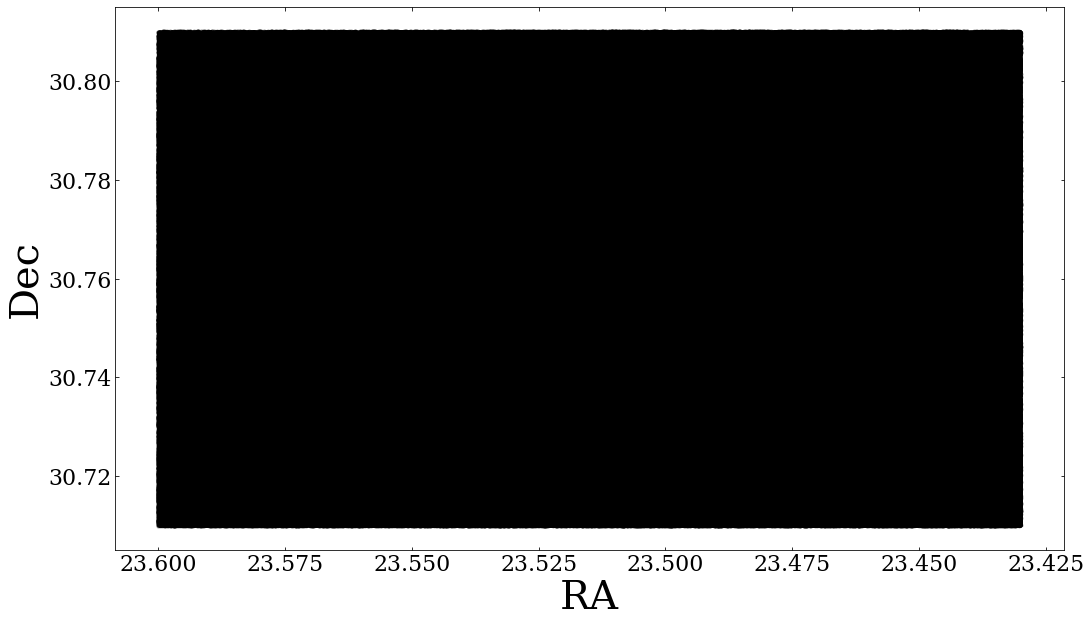

In [11]:
# Define M33 center coordinates and distance in kiloparsecs
ra_m33, dec_m33 = 23.462*u.deg, 30.66*u.deg
sc_m33 = SkyCoord(ra=ra_m33,dec=dec_m33,unit=(u.deg,u.deg),frame='icrs')
dm33 = 859.*u.kpc

# Coordinates for all sources in data subset
ra,dec = ds.RA.evaluate(selection='SUB'),ds.DEC.evaluate(selection='SUB')

# Plot a density map of all sources in the M33 footprint, within the rectangular
# we defined above, to get a feel for the data. 
aspect_ratio = (ra.max()-ra.min())*np.cos(np.pi/180.*dec_m33) / (dec.max()-dec.min())

fig = plt.figure()
fig.set_figwidth(10*aspect_ratio)
fig.set_figheight(10)
ax = plt.subplot(111)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

ax.scatter(ra,dec,s=10,c='black',alpha=0.3)

# Larger RA is to the East, so reversing the direction of the x-axis simulates
# how one would view the image looking up at the real sky
ax.set_xlim(ax.get_xlim()[::-1])

There are way too many to plot individually! Try plotting the density of sources, instead.

(23.599999978748073, 23.430000076877345)

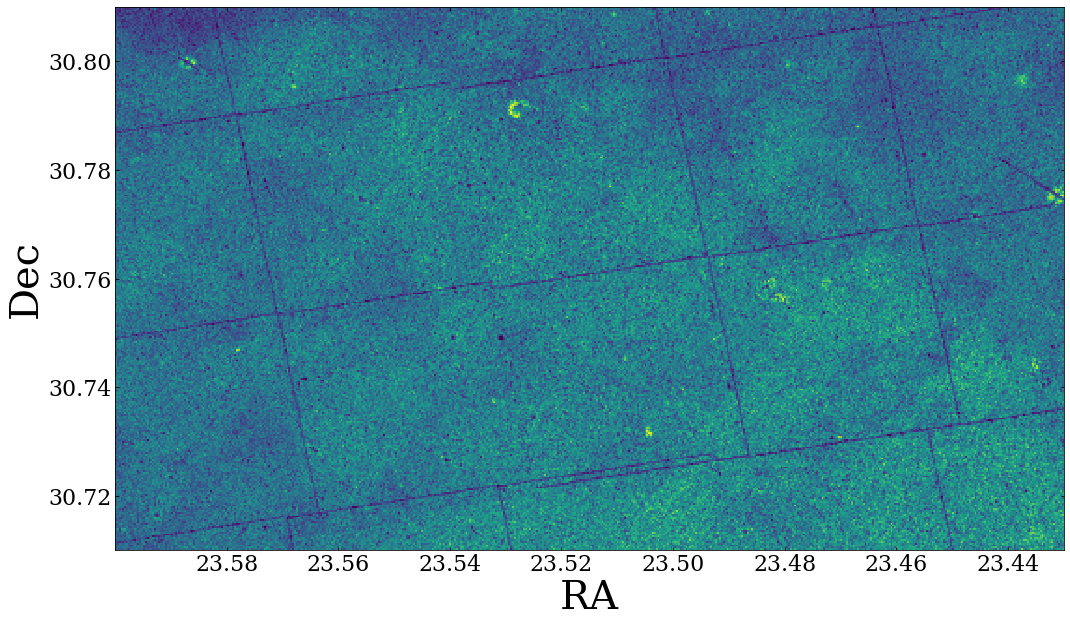

In [5]:
n = 300
hall,hra,hdec = np.histogram2d(ra,dec,
                               bins=[int(n*aspect_ratio),n],
                               density=False)

fig = plt.figure()
fig.set_figwidth(10*aspect_ratio)
fig.set_figheight(10)
ax = plt.subplot(111)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

im = ax.imshow(hall.T,aspect='auto',
               interpolation='nearest',origin='lower',
               extent=[hra[0],hra[-1],hdec[0],hdec[-1]],
               cmap='viridis',vmin=5,vmax=70)

ax.set_xlim(ax.get_xlim()[::-1])

img_scale : log


(34.0, 18.0)

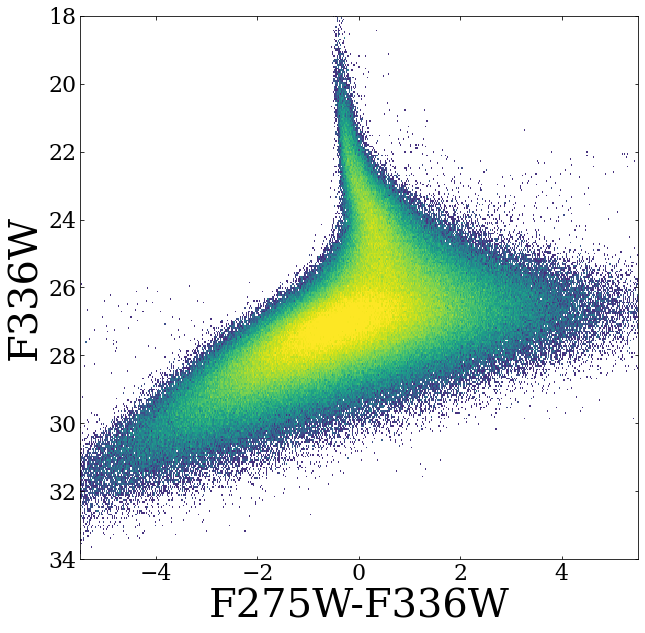

In [27]:
#'F275W_VEGA', 'F336W_VEGA', 'F475W_VEGA', 'F814W_VEGA',  'F110W_VEGA', 'F160W_VEGA'

ds['F275W_F336W'] = ds.F275W_VEGA - ds.F336W_VEGA

F275W_F336W,F336W = ds.F275W_F336W.evaluate(selection='SUB'),ds.F336W_VEGA.evaluate(selection='SUB')

n = 300
hall,h275_336,h336 = np.histogram2d(F275W_F336W,F336W,
                              bins=[int(n*aspect_ratio),n],
                              range=[(-5.5,5.5), (18, 34)],
                              density=False)
import img_scale
hall_scaled = img_scale.log(hall,scale_min=1,scale_max=100)

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = plt.subplot(111)
ax.set_xlabel('F275W-F336W')
ax.set_ylabel('F336W')

colormap = 'viridis'
cmap = getattr(mpl.cm, colormap)
cmap.set_under('w')

im = ax.imshow(hall_scaled.T,aspect='auto',
               interpolation='nearest',origin='lower',
               extent=[h275_336[0],h275_336[-1],h336[0],h336[-1]],
               cmap=cmap,vmin=0.01,vmax=1)

ax.set_ylim(ax.get_ylim()[::-1])

img_scale : log


(32.0, 18.0)

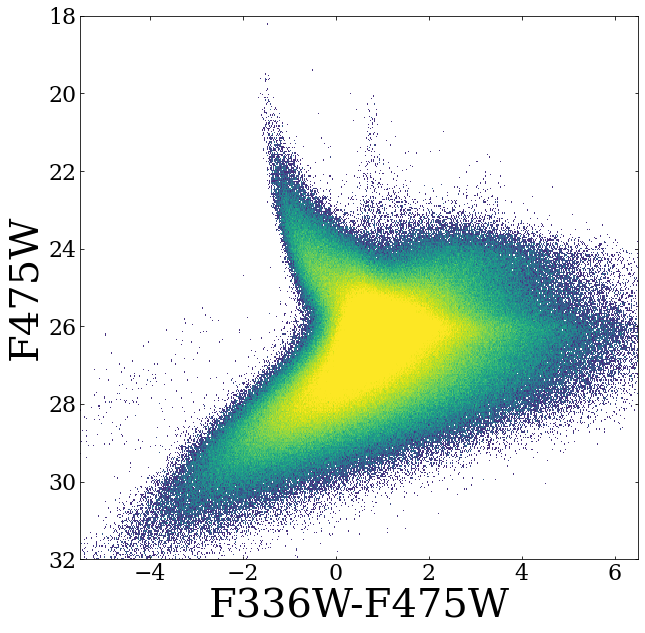

In [29]:
#'F275W_VEGA', 'F336W_VEGA', 'F475W_VEGA', 'F814W_VEGA',  'F110W_VEGA', 'F160W_VEGA'

ds['F336W_F475W'] = ds.F336W_VEGA - ds.F475W_VEGA

F336W_F475W,F475W = ds.F336W_F475W.evaluate(selection='SUB'),ds.F475W_VEGA.evaluate(selection='SUB')

n = 400
hall,h336_475,h475 = np.histogram2d(F336W_F475W,F475W,
                              bins=[int(n*aspect_ratio),n],
                              range=[(-5.5,6.5), (18,32)],
                              density=False)

import img_scale
hall_scaled = img_scale.log(hall,scale_min=1,scale_max=100)

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = plt.subplot(111)
ax.set_xlabel('F336W-F475W')
ax.set_ylabel('F475W')

colormap = 'viridis'
cmap = getattr(mpl.cm, colormap)
cmap.set_under('w')

im = ax.imshow(hall_scaled.T,aspect='auto',
               interpolation='nearest',origin='lower',
               extent=[h336_475[0],h336_475[-1],h475[0],h475[-1]],
               cmap=cmap,vmin=0.01,vmax=1)

ax.set_ylim(ax.get_ylim()[::-1])






img_scale : log


(31.0, 18.0)

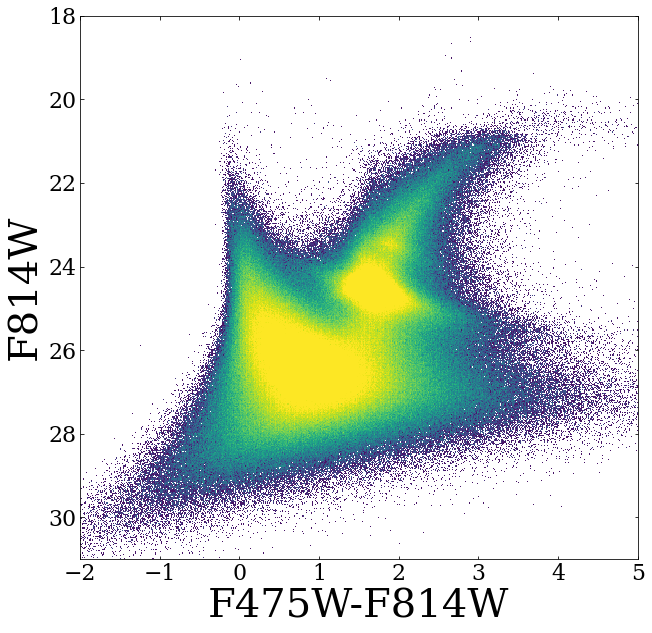

In [31]:
#'F275W_VEGA', 'F336W_VEGA', 'F475W_VEGA', 'F814W_VEGA',  'F110W_VEGA', 'F160W_VEGA'

ds['F475W_F814W'] = ds.F475W_VEGA - ds.F814W_VEGA

F475W_F814W,F814W = ds.F475W_F814W.evaluate(selection='SUB'),ds.F814W_VEGA.evaluate(selection='SUB')

n = 500
hall,h475_814,h814 = np.histogram2d(F475W_F814W,F814W,
                              bins=[int(n*aspect_ratio),n],
                              range=[(-2,5), (18,31)],
                              density=False)

import img_scale
hall_scaled = img_scale.log(hall,scale_min=1,scale_max=100)

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = plt.subplot(111)
ax.set_xlabel('F475W-F814W')
ax.set_ylabel('F814W')

colormap = 'viridis'
cmap = getattr(mpl.cm, colormap)
cmap.set_under('w')

im = ax.imshow(hall_scaled.T,aspect='auto',
               interpolation='nearest',origin='lower',
               extent=[h475_814[0],h475_814[-1],h814[0],h814[-1]],
               cmap=cmap,vmin=0.1,vmax=1)

ax.set_ylim(ax.get_ylim()[::-1])

img_scale : log


(31.0, 18.0)

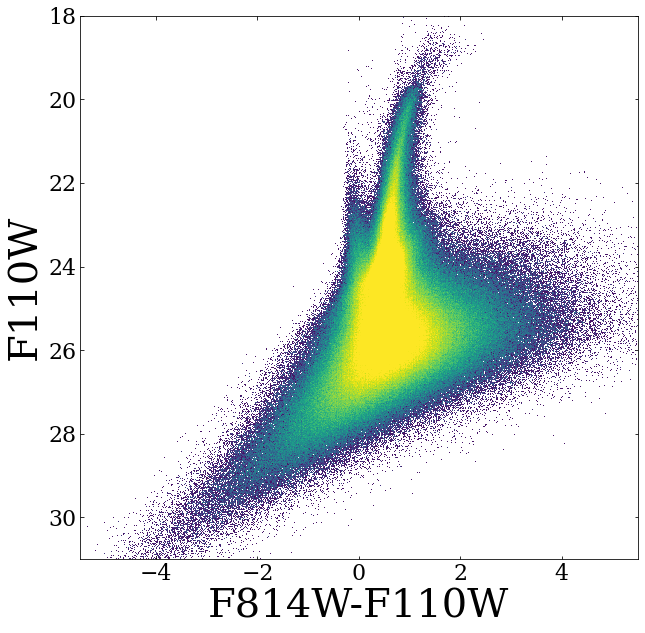

In [34]:
#'F275W_VEGA', 'F336W_VEGA', 'F475W_VEGA', 'F814W_VEGA',  'F110W_VEGA', 'F160W_VEGA'

ds['F814W_F110W'] = ds.F814W_VEGA - ds.F110W_VEGA

F814W_F110W,F110W = ds.F814W_F110W.evaluate(selection='SUB'),ds.F110W_VEGA.evaluate(selection='SUB')

n = 600
hall,h814_110,h110 = np.histogram2d(F814W_F110W,F110W,
                              bins=[int(n*aspect_ratio),n],
                              range=[(-5.5,5.5), (18,31)],
                              density=False)

import img_scale
hall_scaled = img_scale.log(hall,scale_min=1,scale_max=100)

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = plt.subplot(111)
ax.set_xlabel('F814W-F110W')
ax.set_ylabel('F110W')

colormap = 'viridis'
cmap = getattr(mpl.cm, colormap)
cmap.set_under('w')

im = ax.imshow(hall_scaled.T,aspect='auto',
               interpolation='nearest',origin='lower',
               extent=[h814_110[0],h814_110[-1],h110[0],h110[-1]],
               cmap=cmap,vmin=0.1,vmax=1)

ax.set_ylim(ax.get_ylim()[::-1])

img_scale : log


(32.0, 16.0)

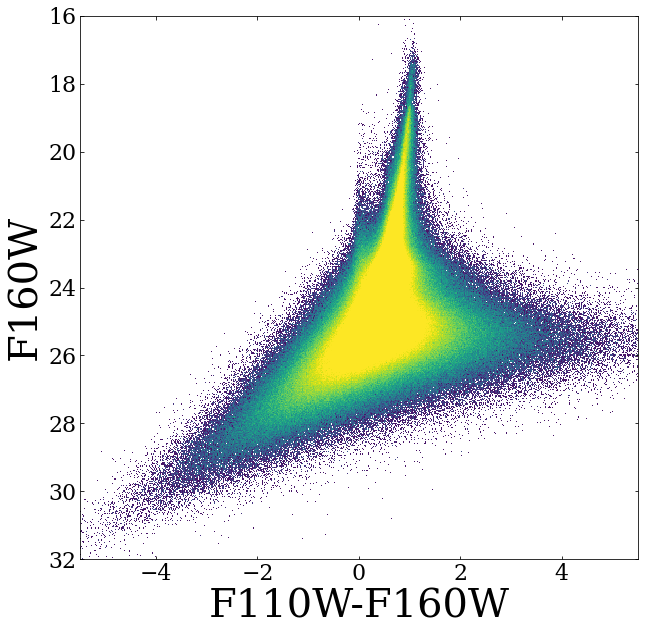

In [36]:
#'F275W_VEGA', 'F336W_VEGA', 'F475W_VEGA', 'F814W_VEGA',  'F110W_VEGA', 'F160W_VEGA'

ds['F110W_F160W'] = ds.F110W_VEGA - ds.F160W_VEGA

F110W_F160W,F160W = ds.F110W_F160W.evaluate(selection='SUB'),ds.F160W_VEGA.evaluate(selection='SUB')

n = 500
hall,h110_160,h160 = np.histogram2d(F110W_F160W,F160W,
                              bins=[int(n*aspect_ratio),n],
                              range=[(-5.5,5.5), (16,32)],
                              density=False)

import img_scale
hall_scaled = img_scale.log(hall,scale_min=1,scale_max=100)

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = plt.subplot(111)
ax.set_xlabel('F110W-F160W')
ax.set_ylabel('F160W')

colormap = 'viridis'
cmap = getattr(mpl.cm, colormap)
cmap.set_under('w')

im = ax.imshow(hall_scaled.T,aspect='auto',
               interpolation='nearest',origin='lower',
               extent=[h110_160[0],h110_160[-1],h160[0],h160[-1]],
               cmap=cmap,vmin=0.1,vmax=1)

ax.set_ylim(ax.get_ylim()[::-1])

## __Now try plotting WISE sources in the same region for comparison__

(23.6076874825, 23.4215903075)

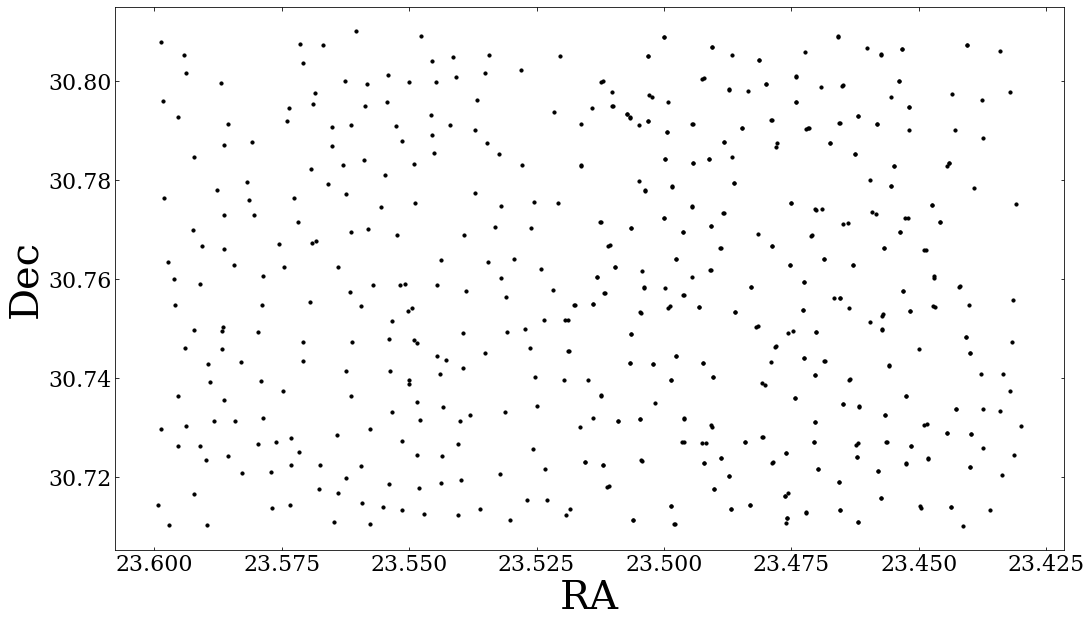

In [ ]:
fig = plt.figure()
fig.set_figwidth(10*aspect_ratio)
fig.set_figheight(10)
ax = plt.subplot(111)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

ax.scatter(table['ra'],table['dec'],s=10,c='black')

ax.set_xlim(ax.get_xlim()[::-1])

In [43]:
def f_to_mag(flux):
  result = 22.5 - 2.5 * np.log10(flux)
  return result

In [45]:
table['W1'] = f_to_mag(table['flux_1'])
table['W2'] = f_to_mag(table['flux_2'])
table['W2 - W1'] = table['W2'] - table['W1']

(18.0, 8.0)

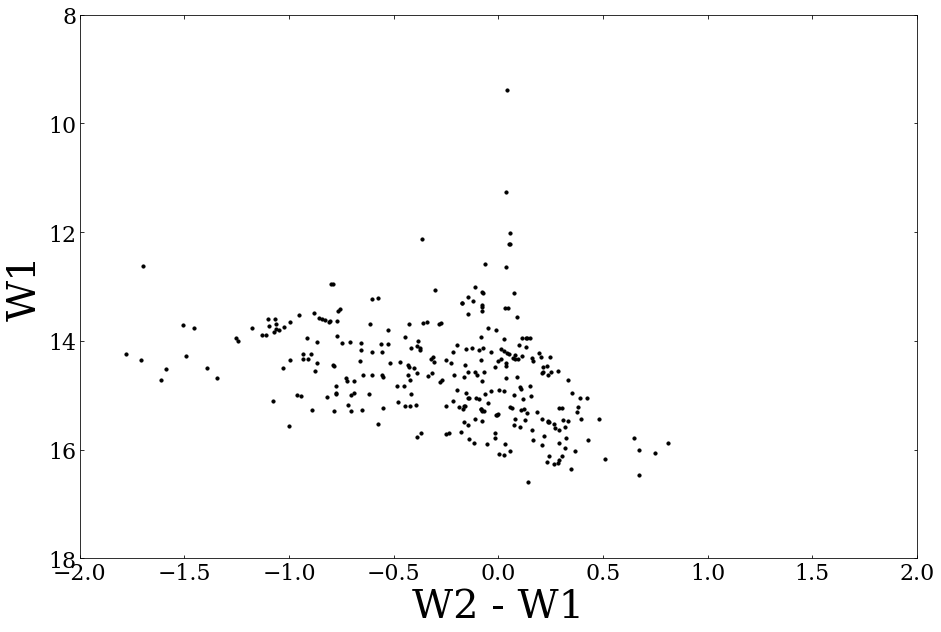

In [48]:
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)
ax = plt.subplot(111)
ax.set_xlabel('W2 - W1')
ax.set_ylabel('W1')
ax.set_xlim(-2,2)
ax.set_ylim(8,18)

ax.scatter(table['W2 - W1'],table['W2'], s=10,c='black')

ax.set_ylim(ax.get_ylim()[::-1])